## Model for outcome in the first 14 days 

In [1]:
# general
import pandas as pd
import numpy as np

from functions import modeling_14d

# plot libarys
import seaborn as sns
import matplotlib.pyplot as plt

# MLflow
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import mlflow
from modeling.config import TRACKING_URI, EXPERIMENT_ID

# Model preparation
#import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
 

# Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# Model Metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score, make_scorer # for modelling.py

# for merging the dataframes
import os, glob
import json

# further libarys
#import itertools
from sklearn.tree import export_graphviz
from collections import Counter

%matplotlib inline

In [2]:
df = pd.read_csv('data/IST_corrected_model.csv',  index_col= [0])

### Target for 14 days after first stroke

Target for the first model is survival (DDEAD == 'Y') within the first 14 days after the (first) stroke.


In [3]:
df.DDEAD.value_counts()

N    15586
Y     1685
Name: DDEAD, dtype: int64

In [4]:
conditions = [df['DDEAD'].eq('N'), df['DDEAD'].eq('Y')]
choices = [1, 0]

df['ALIVE14'] = np.select(conditions, choices, default=np.nan)

In [5]:
df.ALIVE14.value_counts()

1.0    15586
0.0     1685
Name: ALIVE14, dtype: int64

In [6]:
# Select features
features = ['SEX', 'AGE', 'RSBP', 'STYPE']
X = df[features]

# Select target
y = df.ALIVE14

In [7]:
print(sorted(Counter(y).items()))

[(0.0, 1685), (1.0, 15586)]


In [8]:
print(f'Patients deceased: {round((df.ALIVE14.value_counts()[0] / df.shape[0] * 100),1)} %')
print(f'Patients alive: {round((df.ALIVE14.value_counts()[1] / df.shape[0] * 100),1)} %')

Patients deceased: 9.8 %
Patients alive: 90.2 %


We have an imbalanced dataset - with a distribution of 90% alive and 10% deceased patients after an ischaemic stroke. Below 

### Undersampling 

Combined over- and undersampling did not result in better results, neither did changing the 'sampling_strategy'. Thus, we continued with undersampling of the majority class.

In [9]:
# summarize class distribution
print(Counter(y))
# define oversampling strategy
over = RandomOverSampler(sampling_strategy=0.25)
# fit and apply the transform
X, y = over.fit_resample(X, y)
# summarize class distribution
print(Counter(y))
# define undersampling strategy
under = RandomUnderSampler(sampling_strategy=0.5)
# fit and apply the transform
X, y = under.fit_resample(X, y)
# summarize class distribution
print(Counter(y))

Counter({1.0: 15586, 0.0: 1685})
Counter({1.0: 15586, 0.0: 3896})
Counter({1.0: 7792, 0.0: 3896})


In [10]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

In [12]:
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [13]:
print(sorted(Counter(y_under).items()))

[(0.0, 3896), (1.0, 3896)]


In [14]:
# Split the data in test and training set
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.3, random_state=42)

#### Helper functions

In [15]:
def pred_eval_plot_model(X_train, X_test, y_train, y_test, clf, cv=None):
    """Train a single model and print evaluation metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        cv (int, None): Number of cross-validations, default=None
    
    Returns:
        model (sklearn.base.BaseEstimator): The trained model
    """
    model = clf.fit(X_train, y_train)

    if cv:
        cv = cross_validate(m_rf, X_train_trans, y_train, cv=5, verbose=5)
        print(f"Best cross-validated score: {cv['test_score'].mean()}")
    
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print(f"--- MODEL PARAMETERS {'-'*10}")
    print(json.dumps(model.get_params(), indent=4))
    print(f"--- CLASSIFICATION REPORT {'-'*10}")
    print(classification_report(y_test,y_pred))
    print(f"--- CONFUSION MATRIX {'-'*10}")
    print(confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(model, X_test, y_test, display_labels=["deceased", "alive"])
    return model

def _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs):
    """Helper function to perform a grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        gs (BaseSearchCV): SearchCV to train and use
    
    Returns:
        model (BaseSearchCV): The trained grid search
    """
    gs = gs.fit(X_train, y_train)
    
    # Testing predictions (to determine performance)
    y_pred = gs.best_estimator_.predict(X_test)
    
    print(f"--- GRID SEARCH RESULTS {'-'*10}")
    print(f"Best model: {gs.best_params_}")
    print(f"Best cross-validated score: {gs.best_score_}")
    print(f"--- CLASSIFICATION REPORT {'-'*10}")
    print(classification_report(y_test,y_pred))
    print(f"--- CONFUSION MATRIX {'-'*10}")
    print(confusion_matrix(y_test,y_pred))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, y_test, display_labels=["deceased", "alive"])
    return gs
    

def run_rand_grid_search(X_train, X_test, y_train, y_test, clf, params_grid, n_iter=10, cv=5):
    """Perform a randomized grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        params_grid (dict): Dictionary defining the parameters for the grid search
        n_iter (int): Number of grid search combinations to run
        cv (int, None): Number of cross-validations, default=None
        
    Returns:
        model (BaseSearchCV): The trained grid search
    """
    gs = RandomizedSearchCV(clf, params_grid, n_iter=n_iter, cv=cv, random_state=24, verbose=5)
    return _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs)
    
def run_grid_search(X_train, X_test, y_train, y_test, clf, params_grid, cv=5):
    """Perform a grid search and calculate performance metrics.
    
    Args:
        X_train (pd.DataFrame, np.array): Features of the training set
        X_test (pd.DataFrame, np.array): Features of thee test set
        y_train (pd.Series, np.array): Target of the training set
        y_teset (pd.Seeries, np.array): Target of the test set
        clf (sklearn.base.BaseEstimator): Estimator to train and use
        params_grid (dict): Dictionary defining the parameters for the grid search
        cv (int, None): Number of cross-validations, default=None
        
    Returns:
        model (BaseSearchCV): The trained grid search
    """
    gs = GridSearchCV(clf, params_grid, cv=cv, verbose=5)
    return _pred_eval_plot_grid(X_train, X_test, y_train, y_test, gs)
    

### Preparation of Data Scaling and Category Encoding
Some models need scaling of numerical features and encoding of categorical features. The sklearn preprocessors are instantiated here and used where necessary in the data transformation step of each model.

In [16]:
# encoder for categories
onehot = OneHotEncoder(drop="first")

# scalers for numerical features
mms = MinMaxScaler()
ss = StandardScaler()

# Prepare list of numerical and categorical columns
num_cols = make_column_selector(dtype_include=np.number)
cat_cols = make_column_selector(dtype_include="object")

### Choosing a metric

We need to define a suitable metric for evaluating model performance. We saw earlier, that we have an imbalanced dataset. Therefore, we use F1-Score for model selection during grid search.

For our final model selection and parameter tuning, we want to be sure that we predict the survival only in case the patient really was alive after 14 days. Hence, we use precision as final model metric.

## Training models and Tracking with MLflow

In [17]:
!ps -A | grep gunicorn

 4009 ttys001    0:01.12 /Users/Nicole/Documents/Data_Science/neuefische/misc-basics/ds-modeling-pipeline-template/.venv/bin/python /Users/Nicole/Documents/Data_Science/neuefische/misc-basics/ds-modeling-pipeline-template/.venv/bin/gunicorn -b 127.0.0.1:5000 -w 1 mlflow.server:app
 4011 ttys001    0:01.83 /Users/Nicole/Documents/Data_Science/neuefische/misc-basics/ds-modeling-pipeline-template/.venv/bin/python /Users/Nicole/Documents/Data_Science/neuefische/misc-basics/ds-modeling-pipeline-template/.venv/bin/gunicorn -b 127.0.0.1:5000 -w 1 mlflow.server:app
 6019 ttys003    0:00.02 /bin/zsh -c ps -A | grep gunicorn
 6021 ttys003    0:00.00 grep gunicorn


In [6]:

# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.get_experiment(EXPERIMENT_NAME)
mlflow.start_run()
#run = mlflow.active_run()

2021/04/07 18:24:17 ERROR mlflow.utils.rest_utils: API request to https://hudsju377cddpoevnjdkfnvpwovniewnipcdsnkvn.mlflow.neuefische.de/api/2.0/mlflow/experiments/get failed with code 500 != 200, retrying up to 2 more times. API response body: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>

2021/04/07 18:24:20 ERROR mlflow.utils.rest_utils: API request to https://hudsju377cddpoevnjdkfnvpwovniewnipcdsnkvn.mlflow.neuefische.de/api/2.0/mlflow/experiments/get failed with code 500 != 200, retrying up to 1 more times. API response body: <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">
<title>500 Internal Server Error</title>
<h1>Internal Server Error</h1>
<p>The server encountered an internal error and was unable to complete your request. Either

MlflowException: API request to https://hudsju377cddpoevnjdkfnvpwovniewnipcdsnkvn.mlflow.neuefische.de/api/2.0/mlflow/experiments/get failed to return code 200 after 3 tries

In [5]:
EXPERIMENT_NAME

'Stroke_Nicole'

In [4]:
from  mlflow.tracking import MlflowClient
client = MlflowClient()
experiments = client.list_experiments() # returns a list of mlflow.entities.Experiment

In [5]:
run = client.create_run(experiments[EXPERIMENT_ID].experiment_id) # returns mlflow.entities.Run
client.log_param(run.info.run_id, "hello", "world")

In [7]:
print(experiments)

[<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/1', experiment_id='1', lifecycle_stage='active', name='some-experiment', tags={}>, <Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/3', experiment_id='3', lifecycle_stage='active', name='0-template-ds-modeling', tags={}>, <Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/5', experiment_id='5', lifecycle_stage='active', name='the-fitters-group', tags={}>, <Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/6', experiment_id='6', lifecycle_stage='active', name='nlp-trio', tags={}>, <Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/7', experiment_id='7', lifecycle_stage='active', name='Stroke_Nicole', tags={}>]


In [9]:
#!mlflow ui

^C


In [12]:
client.log_param(run.info.run_id, 'Hyper1', 1)
client.log_metric(run.info.run_id, "-" + "MSE", 1)
client.set_tag(run.info.run_id, "worst_model", "True")

In [13]:
mlflow.end_run()

### Logistic Regression with Standard Scaler

In [31]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", ss, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": null,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.55      0.36      0.43      1181
         1.0       0.72      0.85      0.78      2326

    accuracy                           0.69      3507
   macro avg       0.64      0.60      0.61      3507
weighted avg       0.67      0.69      0.66      3507

--- CONFUSION MATRIX ----------
[[ 422  759]
 [ 344 1982]]


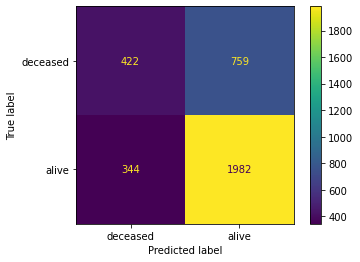

In [34]:
logreg_ss = LogisticRegression(max_iter=400)
m_logreg_ss = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg_ss)

The simple logistic model with standard scaling of the numerical features achieves an accuracy of 66% and a recall of 71% on deceased patients.

In [36]:
# Classification report
y_probs = m_logreg_ss.predict_proba(X_test_trans)[:, 1]

y_pred = y_probs > 0.95
print(f"--- CLASSIFICATION REPORT {'-'*10}")
print(classification_report(y_test,y_pred))
print(f"--- CONFUSION MATRIX {'-'*10}")
print(confusion_matrix(y_test,y_pred))

--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

         0.0       0.34      1.00      0.51      1181
         1.0       1.00      0.02      0.03      2326

    accuracy                           0.35      3507
   macro avg       0.67      0.51      0.27      3507
weighted avg       0.78      0.35      0.19      3507

--- CONFUSION MATRIX ----------
[[1181    0]
 [2288   38]]


### Logistic Regression with MinMax Scaling

In [15]:
# Define transformer
transformer = ColumnTransformer([
    ("scale", mms, num_cols),
    ("encode", onehot, cat_cols),
])

# Transform
X_train_trans = transformer.fit_transform(X_train)
X_test_trans = transformer.transform(X_test)

--- MODEL PARAMETERS ----------
{
    "C": 1.0,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 400,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l2",
    "random_state": null,
    "solver": "lbfgs",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
--- CLASSIFICATION REPORT ----------
              precision    recall  f1-score   support

           N       0.70      0.69      0.70       521
           Y       0.68      0.69      0.68       490

    accuracy                           0.69      1011
   macro avg       0.69      0.69      0.69      1011
weighted avg       0.69      0.69      0.69      1011

--- CONFUSION MATRIX ----------
[[358 163]
 [151 339]]


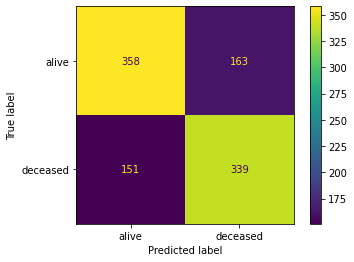

In [16]:
# Calculate the LogisticRegression
logreg = LogisticRegression(max_iter=400)
m_logreg_mm = pred_eval_plot_model(X_train_trans, X_test_trans, y_train, y_test, logreg)

The simple logistic model with MinMax scaling of the numerical features achieves an accuracy of 66% and a recall of 70% on deceased patients.

In [17]:
### Logistic Regression with Randomized Grid Search

In [ ]:
params_grid = {
    "penalty": ["elasticnet"],
    "C": np.logspace(-3, 3, 7),
    "max_iter": [200],
    "l1_ratio": np.arange(0, 1, 0.25),
    "solver": ["saga"],
}
rs_logreg = run_rand_grid_search(X_train_trans, X_test_trans, y_train, y_test, logreg, params_grid, cv=3, n_iter=20)